In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

import candas as can
import gumbi as gmb
from candas.test import FluorescenceData, QuantStudio

base_pth, code_pth, data_pth, rslt_pth, fig_pth = can.utils.setup_paths()
plt.style.use(str(can.style.futura))

%config InlineBackend.figure_format = 'retina'

# JG075F: L-MMMMx blocker tripartite competition matrix

In [2]:
cmax = 50

JG075F = (
    QuantStudio(rslt_pth / 'JG075F L-MMMMx blocker tripartite competition matrix.xlsx', 'JG075F')
    .import_data()
    .format_reactions()
    .index_reactions()
    .subtract_background()
    .normalize_reactions(cmax=cmax)
    .invert_fluorophore('FAM')
)

# Denote reaction conditions
JG075F.reactions.wide = (
    JG075F.reactions.wide
    .drop(columns=['Sample'])
    .merge(pd.read_csv(base_pth / 'Experimental' / 'JG075F Plate Map.csv'), on='Well')
#     .assign(lg10_Blocker = lambda df: np.log10(df['Blocker μM']))
#     .replace({'lg10_Blocker': {-np.inf: -2}})
#     .drop(columns=['CT','lg10_Copies','Target'])
)


JG075F.reactions.neaten()
JG075F.extract_endpoints(cmax=cmax)
endpoints = JG075F.endpoints
JG075F.reactions

,Experiment,Well,Target,lg10_Copies,Outlier,WellPosition,Copies,Reporter,Task,Comments,...,Reaction,WT_lg10_Copies,SNV_lg10_Copies,Blocker μM,WellName,Sample,Blocker,Cycle,Fluorescence,Corr_Fluorescence
0,JG075F,1,FAM,-inf,False,A1,0.0,FAM,UNKNOWN,,...,0,1,-2,0.0,A1,JG075F_001,L-MMMMx,1,0.000313,0.002408
1,JG075F,1,FAM,-inf,False,A1,0.0,FAM,UNKNOWN,,...,0,1,-2,0.0,A1,JG075F_001,L-MMMMx,2,0.001418,0.001183
2,JG075F,1,FAM,-inf,False,A1,0.0,FAM,UNKNOWN,,...,0,1,-2,0.0,A1,JG075F_001,L-MMMMx,3,0.000909,0.001057
3,JG075F,1,FAM,-inf,False,A1,0.0,FAM,UNKNOWN,,...,0,1,-2,0.0,A1,JG075F_001,L-MMMMx,4,0.001478,0.000197
4,JG075F,1,FAM,-inf,False,A1,0.0,FAM,UNKNOWN,,...,0,1,-2,0.0,A1,JG075F_001,L-MMMMx,5,0.000998,0.000052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44755,JG075F,384,HEX,-inf,False,P24,0.0,HEX,UNKNOWN,,...,745,8,7,10.0,P24,JG075F_384,L-MMMMx,56,0.912887,0.583515
44756,JG075F,384,HEX,-inf,False,P24,0.0,HEX,UNKNOWN,,...,745,8,7,10.0,P24,JG075F_384,L-MMMMx,57,0.915925,0.585299
44757,JG075F,384,HEX,-inf,False,P24,0.0,HEX,UNKNOWN,,...,745,8,7,10.0,P24,JG075F_384,L-MMMMx,58,0.917827,0.586347
44758,JG075F,384,HEX,-inf,False,P24,0.0,HEX,UNKNOWN,,...,745,8,7,10.0,P24,JG075F_384,L-MMMMx,59,0.922703,0.589323


/home/johngoertz/miniconda3/envs/candas/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)
/home/johngoertz/miniconda3/envs/candas/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)
/home/johngoertz/miniconda3/envs/candas/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)
/home/johngoertz/miniconda3/envs/candas/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decoratio

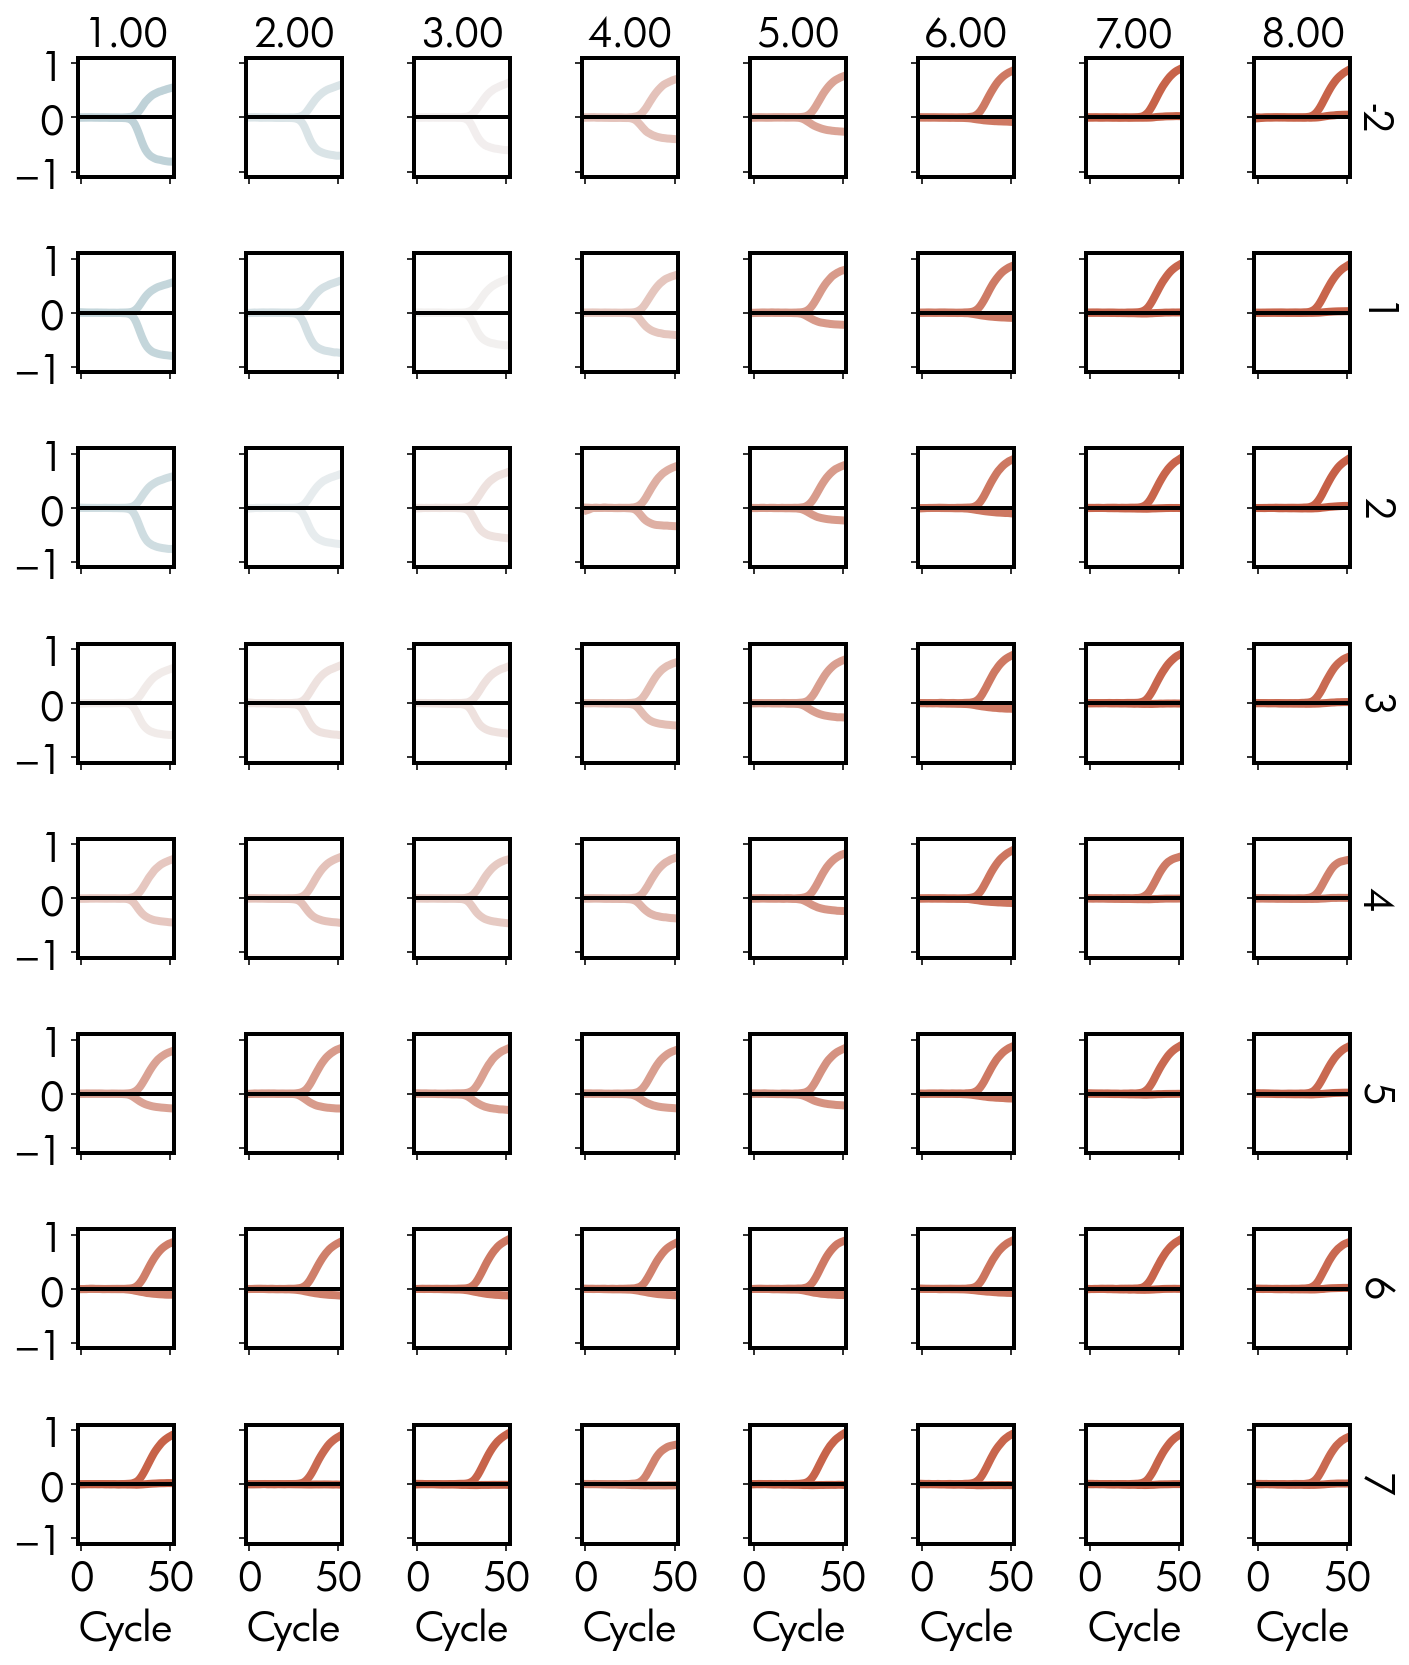

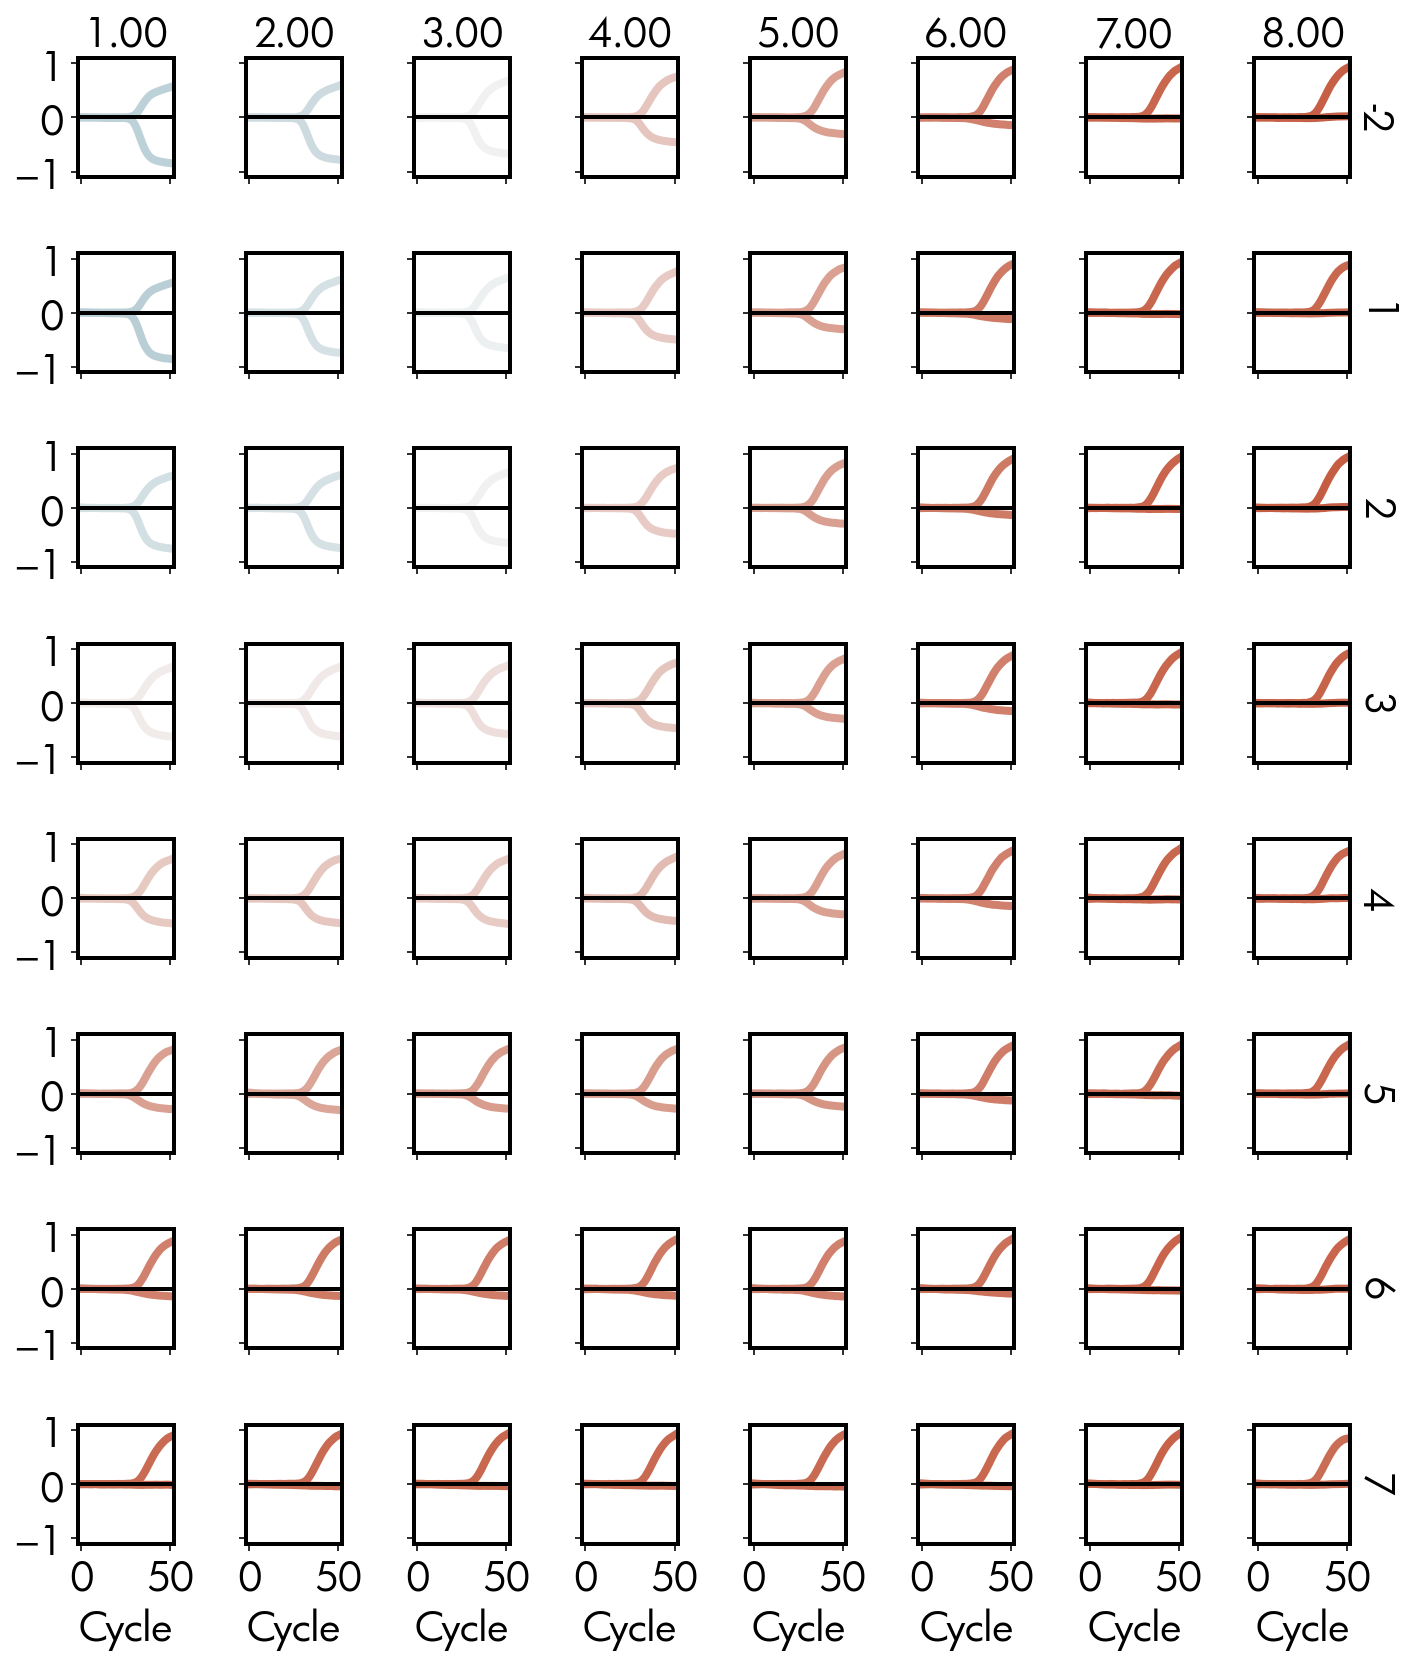

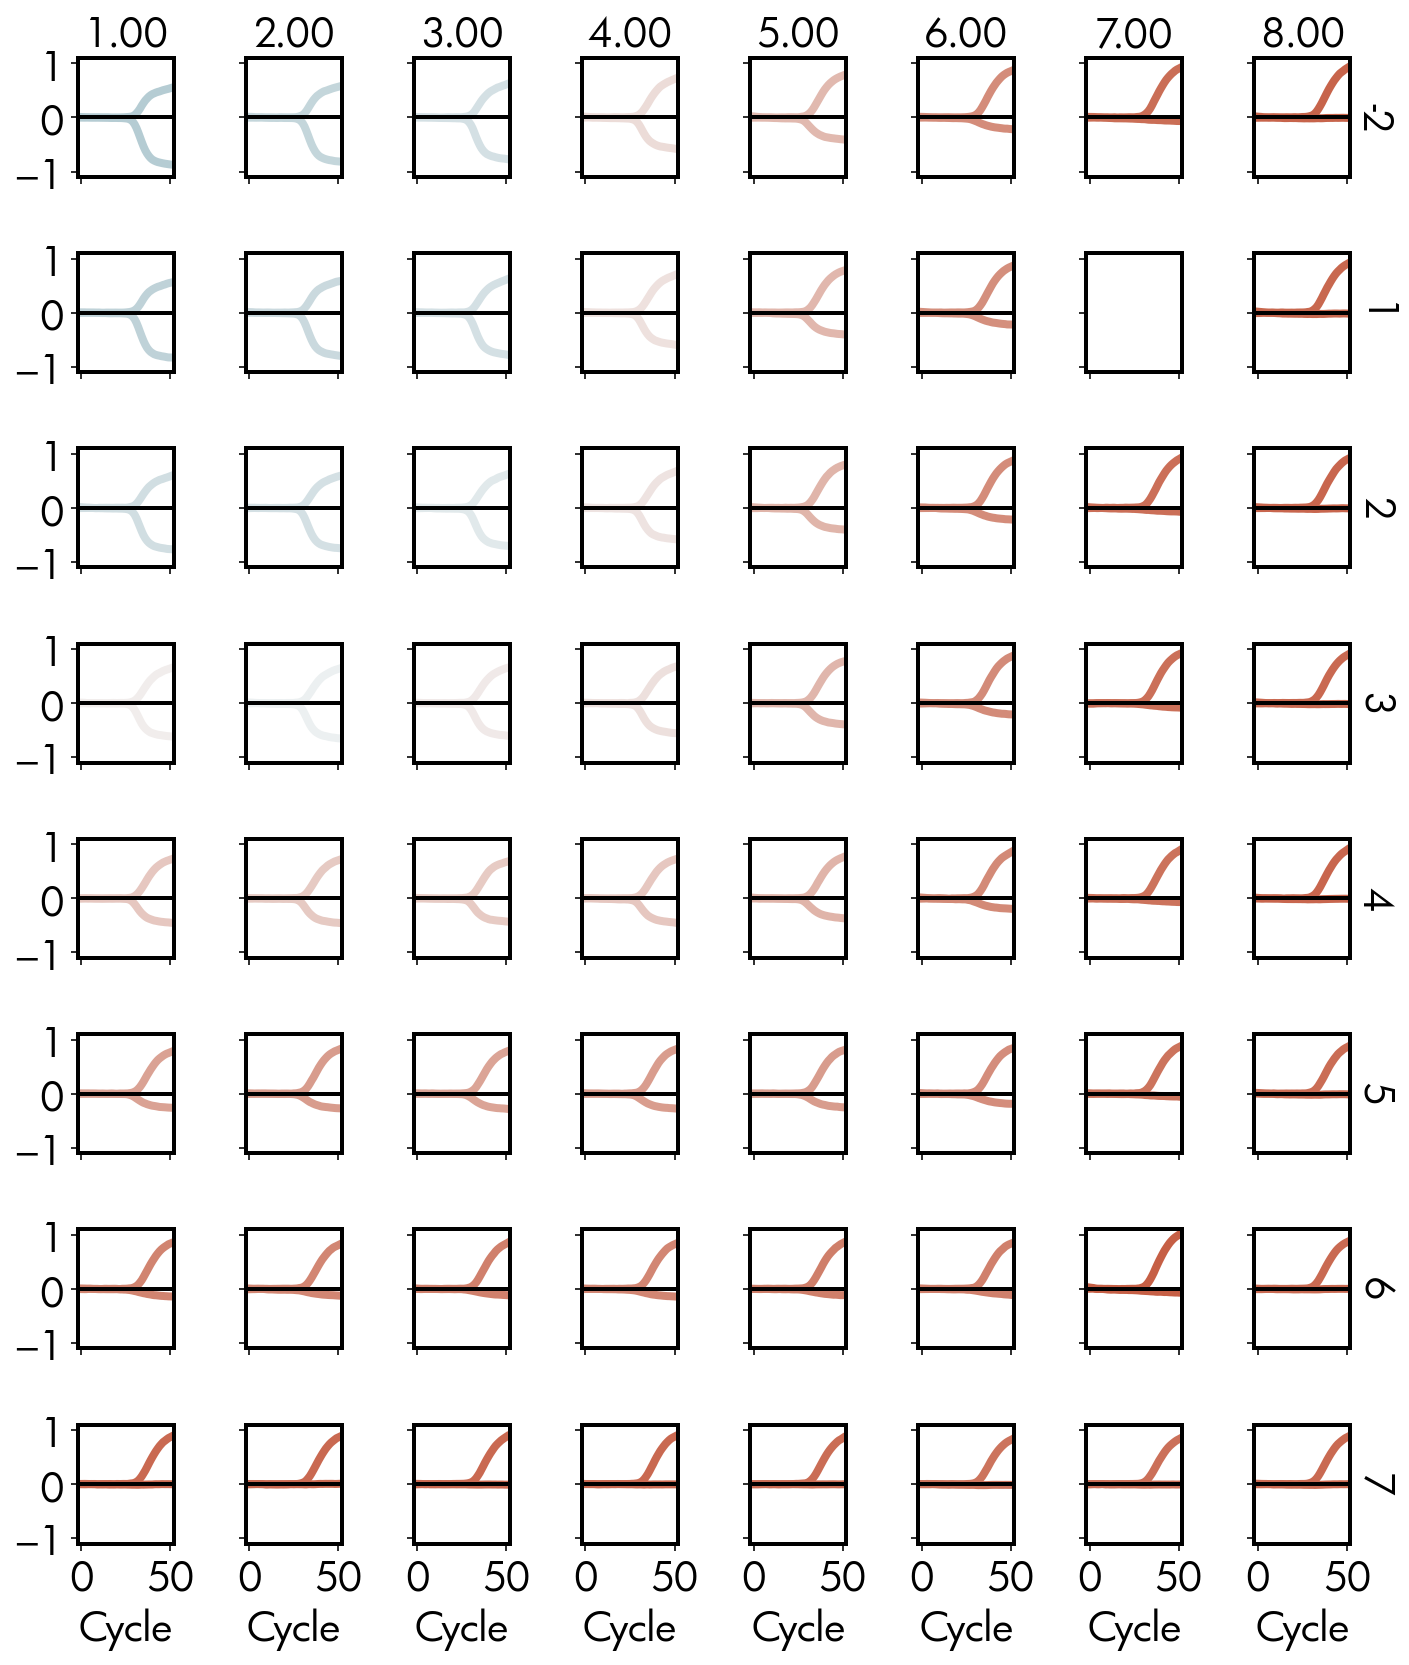

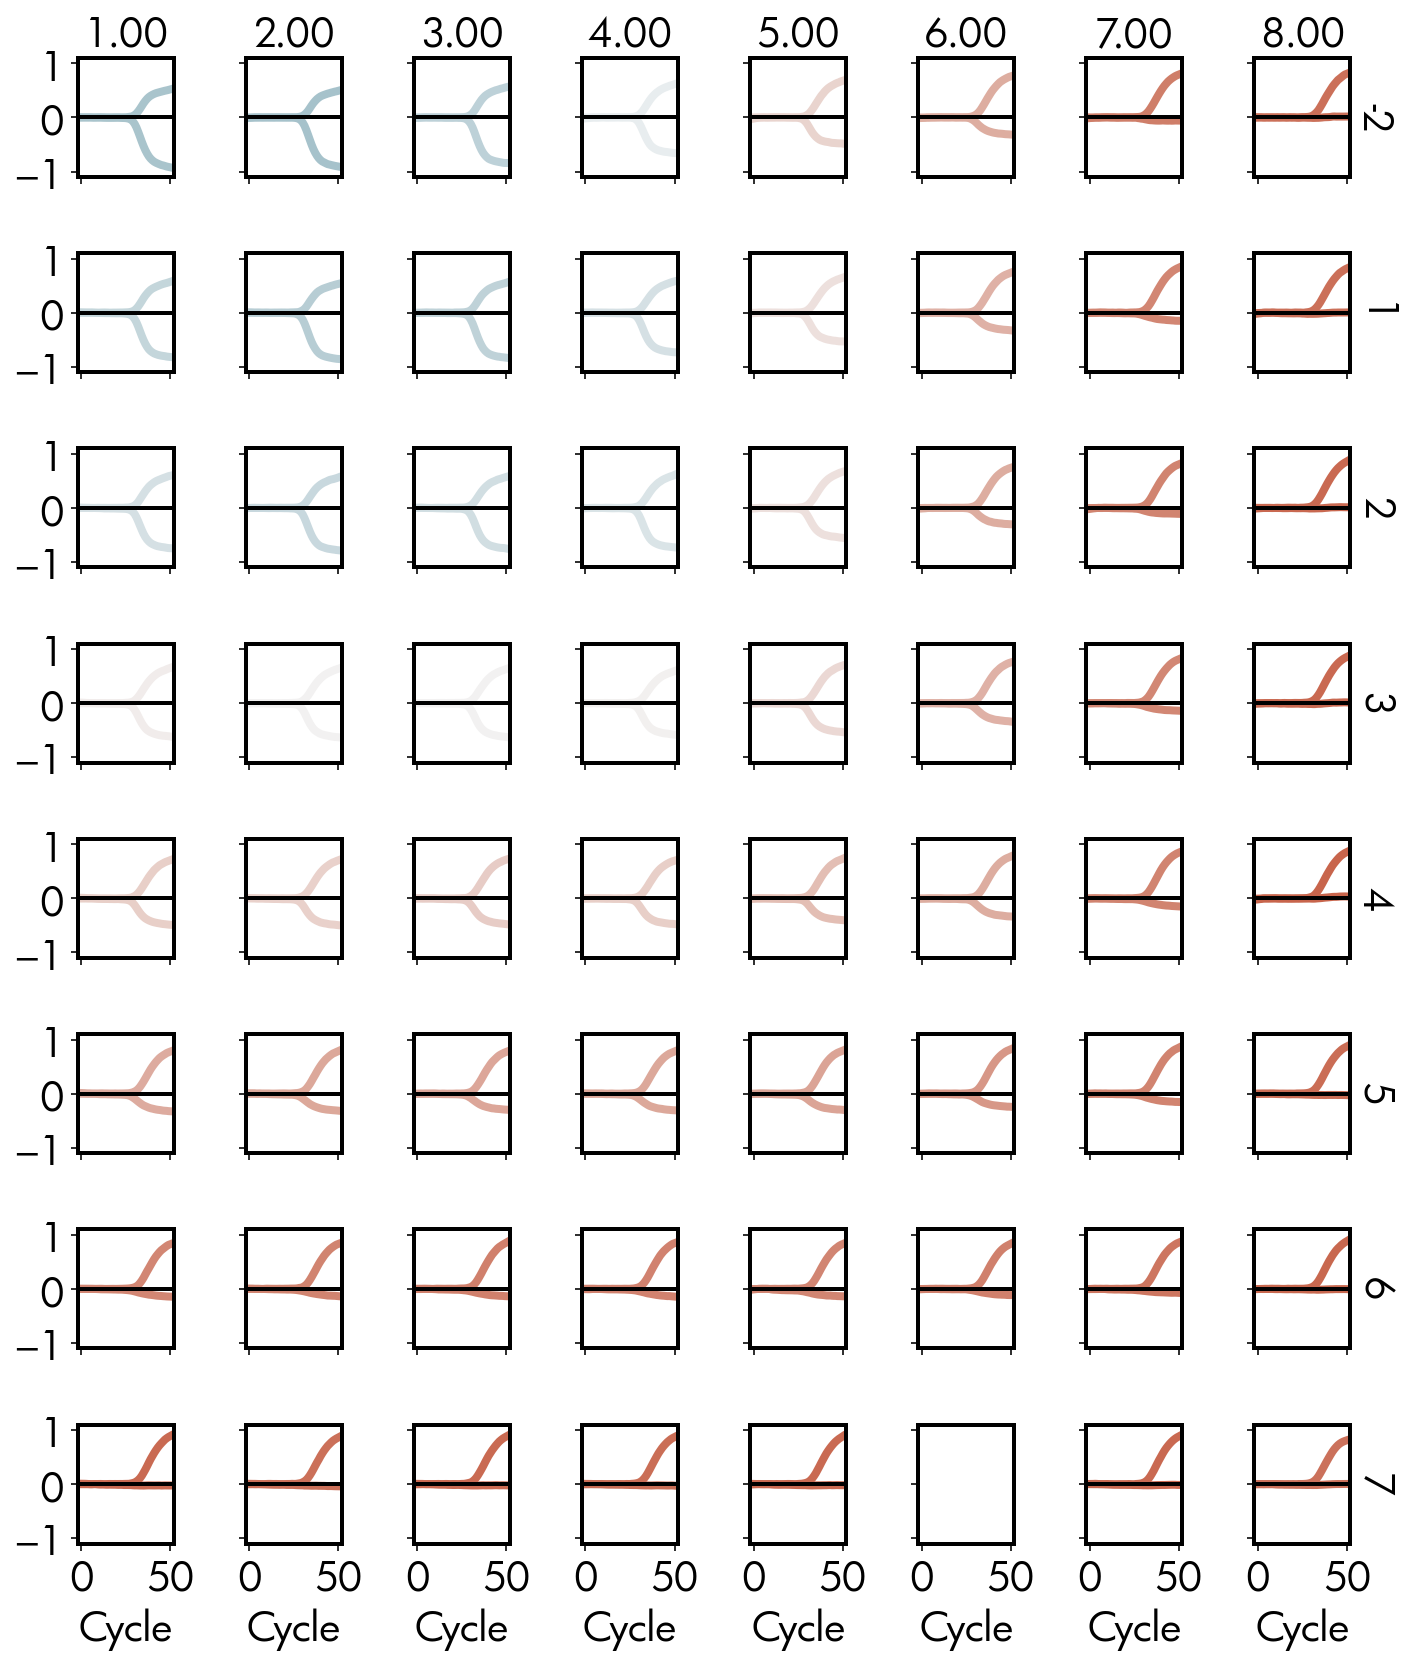

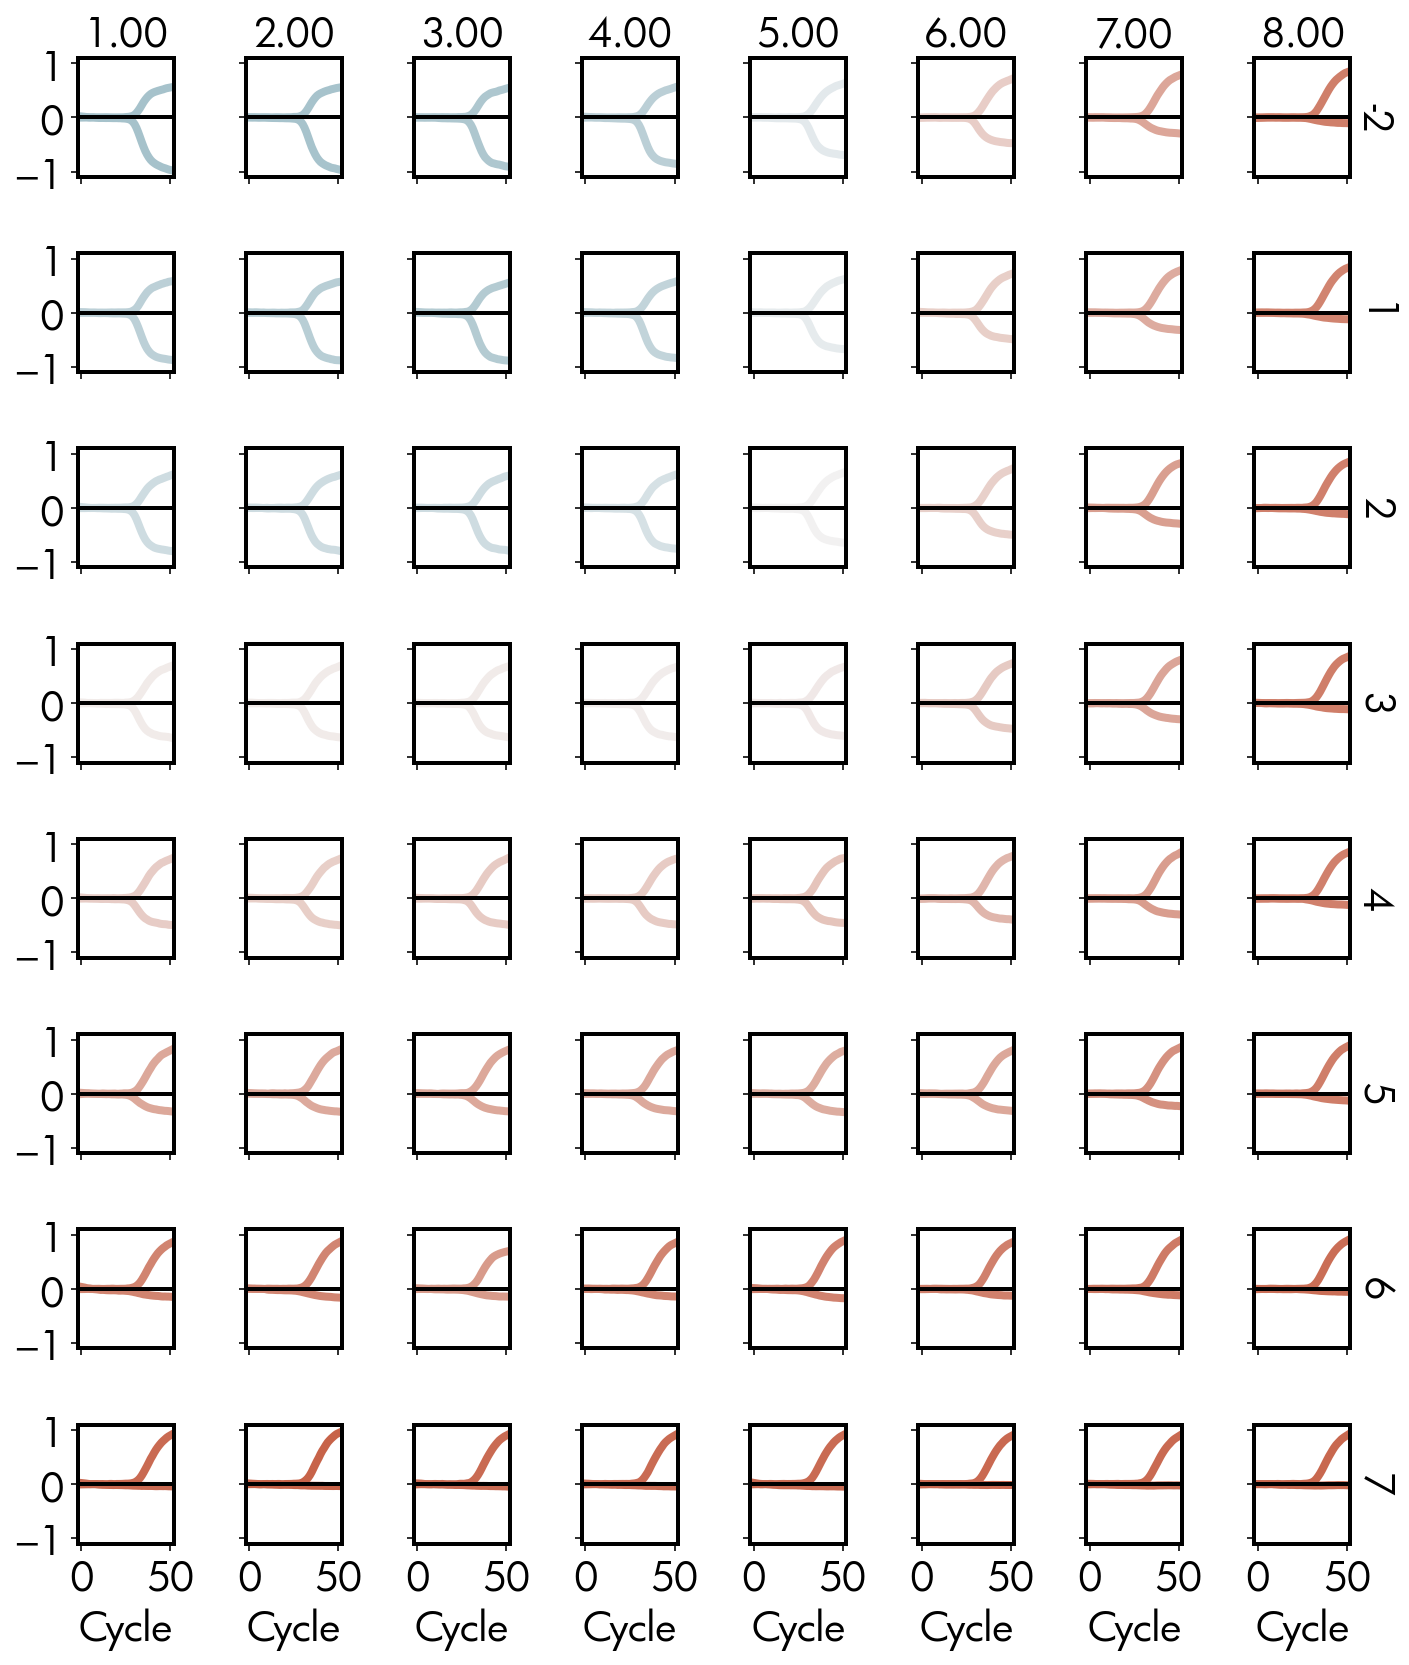

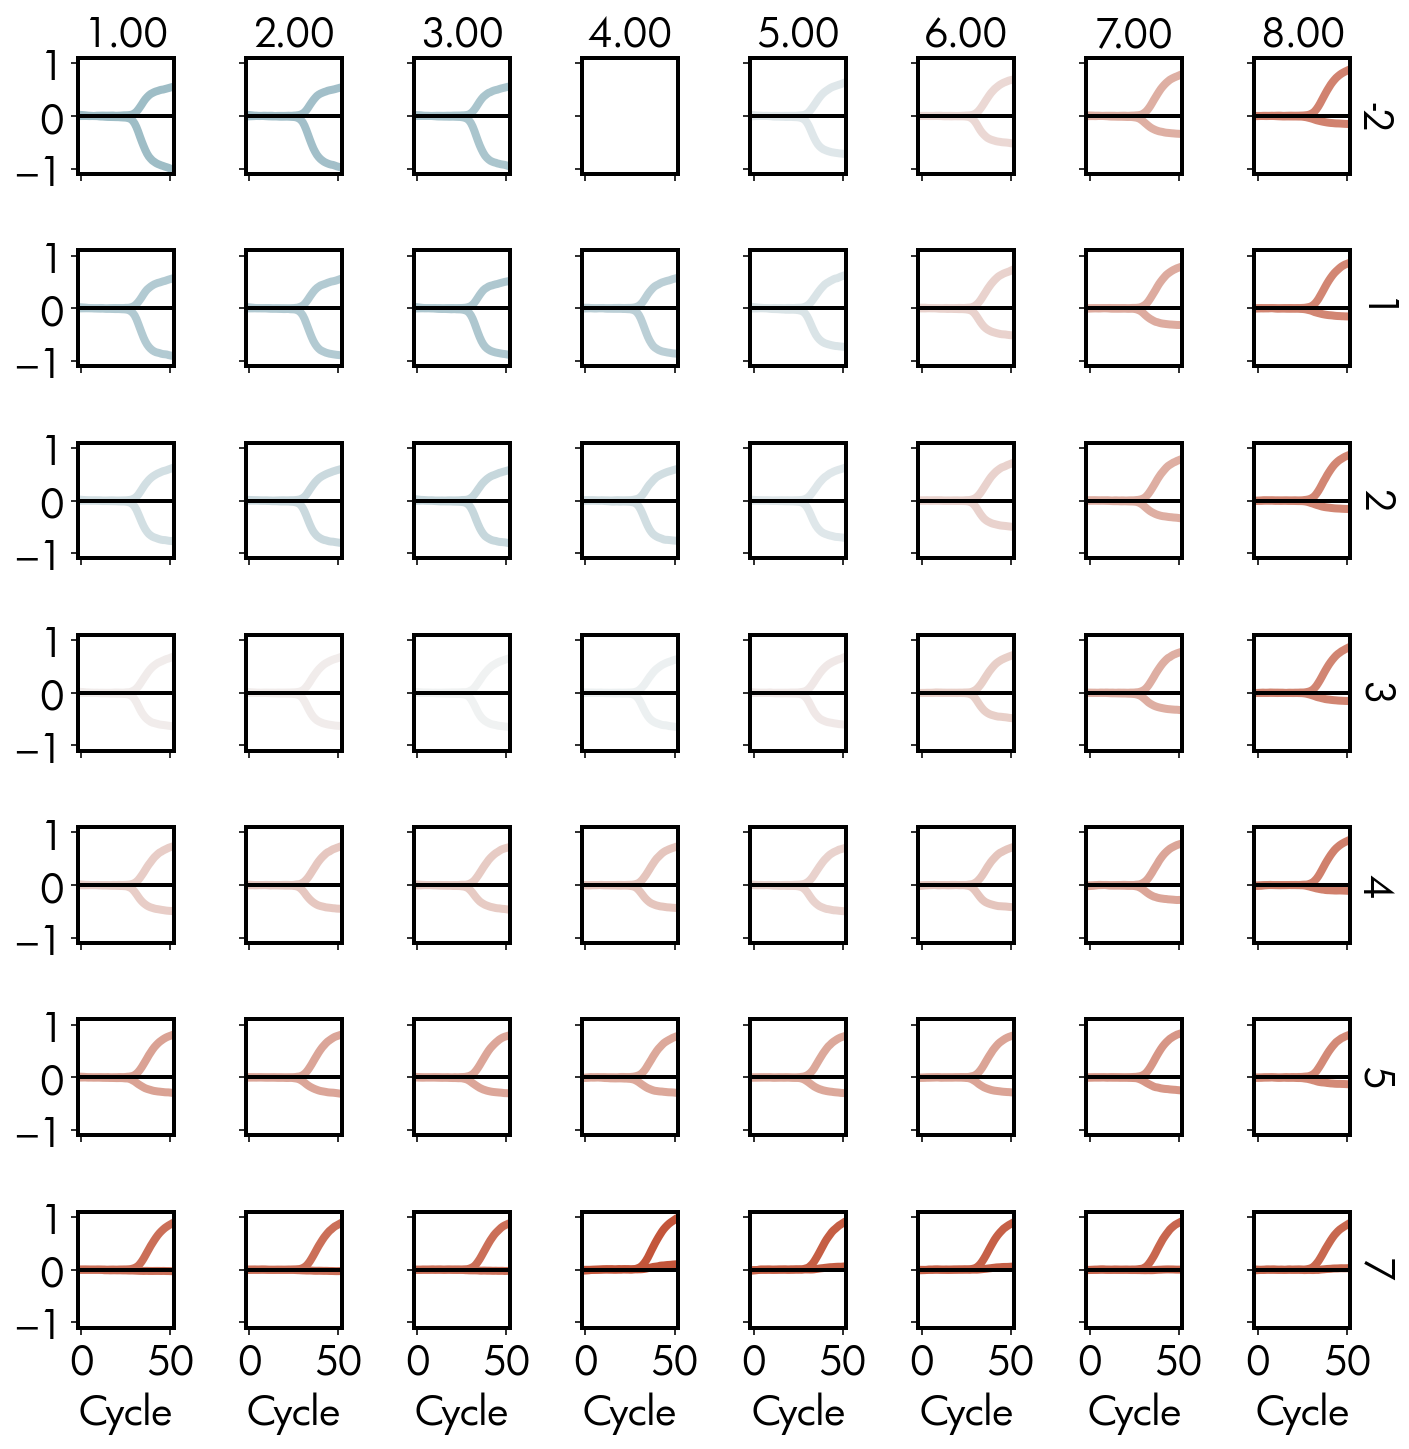

In [3]:
hue = 'SignalDifference'
extent = np.max(np.abs(JG075F.endpoints[hue]))
norm = mpl.colors.Normalize(vmin=-1, vmax=+1)
palette = sns.diverging_palette(220, 20, as_cmap=True)


for blocker_μM in JG075F.endpoints['Blocker μM'].unique():
    data = JG075F.reactions.data.merge(JG075F.endpoints[['Well','SignalDifference']], on='Well')
    data = data[
        (data.Cycle<=cmax) &
        (data['Blocker μM']==blocker_μM)
    ]

    g = sns.relplot(data = data,
                    x='Cycle', y='Fluorescence', col='WT_lg10_Copies', row='SNV_lg10_Copies',
                    units='Reaction', hue = hue, hue_norm=norm, 
                    legend = False, palette=palette, 
                    kind='line', estimator=None, 
                    height=1.5, aspect=0.85, linewidth=4,
                    facet_kws={
                        'margin_titles': True,
                        'despine': False})

    g.refline(y=0, color='k', linestyle='-')
    g.set_titles(col_template="{col_name:.2f}", row_template="{row_name}")
    g.set(ylim=[-1.1, 1.1], xlim=[-2, cmax+2], ylabel='')
    # g.set_titles(col_template="", row_template="")
    plt.tight_layout();

    # can.utils.savefig('JG075A GBP6 Tripartite Curves')

In [4]:
nonblank_endpoints = endpoints.query('SNV_lg10_Copies > 0')

ds = gmb.DataSet(nonblank_endpoints, outputs=['SignalDifference'])
gp = gmb.GP(ds).fit(continuous_dims = ['WT_lg10_Copies', 'SNV_lg10_Copies', 'Blocker μM'],
                   linear_dims = ['WT_lg10_Copies', 'SNV_lg10_Copies', 'Blocker μM']
                   )

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Saving..Done


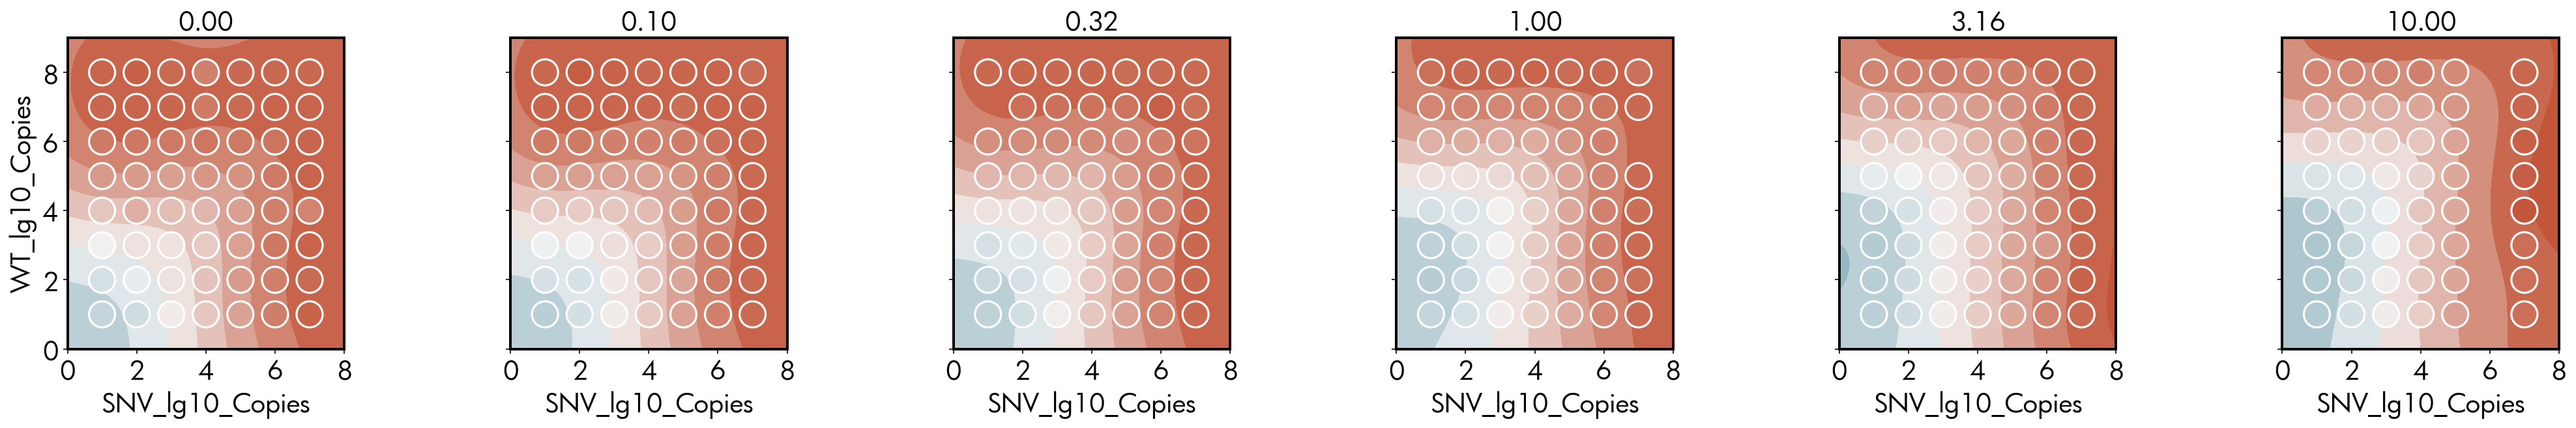

In [5]:
hue = 'SignalDifference'
extent = np.max(np.abs(nonblank_endpoints[hue]))
norm = mpl.colors.Normalize(vmin=-extent, vmax=+extent)
norm = mpl.colors.Normalize(vmin=-1, vmax=+1)
palette = sns.diverging_palette(220, 20)#, as_cmap=True)
cmap = sns.diverging_palette(220, 20, as_cmap=True)

g = sns.relplot(data=nonblank_endpoints, col="Blocker μM",
                x = 'SNV_lg10_Copies', y='WT_lg10_Copies',
                hue='SignalDifference', hue_norm=norm,
                palette=cmap, legend=False,
                kind='scatter', height=5, aspect=1.0, s=20**2, zorder=10,
                facet_kws={
                    'margin_titles': True,
                    'despine': False})

# g.refline(y=0, color='k', linestyle=':', zorder=-11)
g.set_titles(col_template="{col_name:.2f}", row_template="{row_name}")
g.set(xticks=[0, 2, 4, 6, 8])

for col_val, ax in g.axes_dict.items():
    
    ax.set_aspect('equal')
    ax.set(yticks=[0,2,4,6,8], xticks=[0,2,4,6,8], ylim=[0,9], xlim=[0,8]);
    
    at = gp.parray(**{'Blocker μM': col_val})
    limits = gp.parray(SNV_lg10_Copies=[0,8], WT_lg10_Copies=[0,9])
    XY = gp.prepare_grid(at=at, limits=limits)
    SNV = XY['SNV_lg10_Copies']
    WT = XY['WT_lg10_Copies']
    sig = gp.predict_grid(with_noise=False)
    
    plt.sca(ax)
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    pc = gmb.ParrayPlotter(x=SNV, y=WT, z=sig)(plt.contourf, cmap=cmap, norm=norm, zorder=-10)
    
plt.tight_layout();

# # can.utils.savefig('JG075A GBP6 Tripartite Curves')
can.utils.savefig(f'JG075F Signal Response Surfaces by Blocker μM', path=fig_pth)

Saving..Done


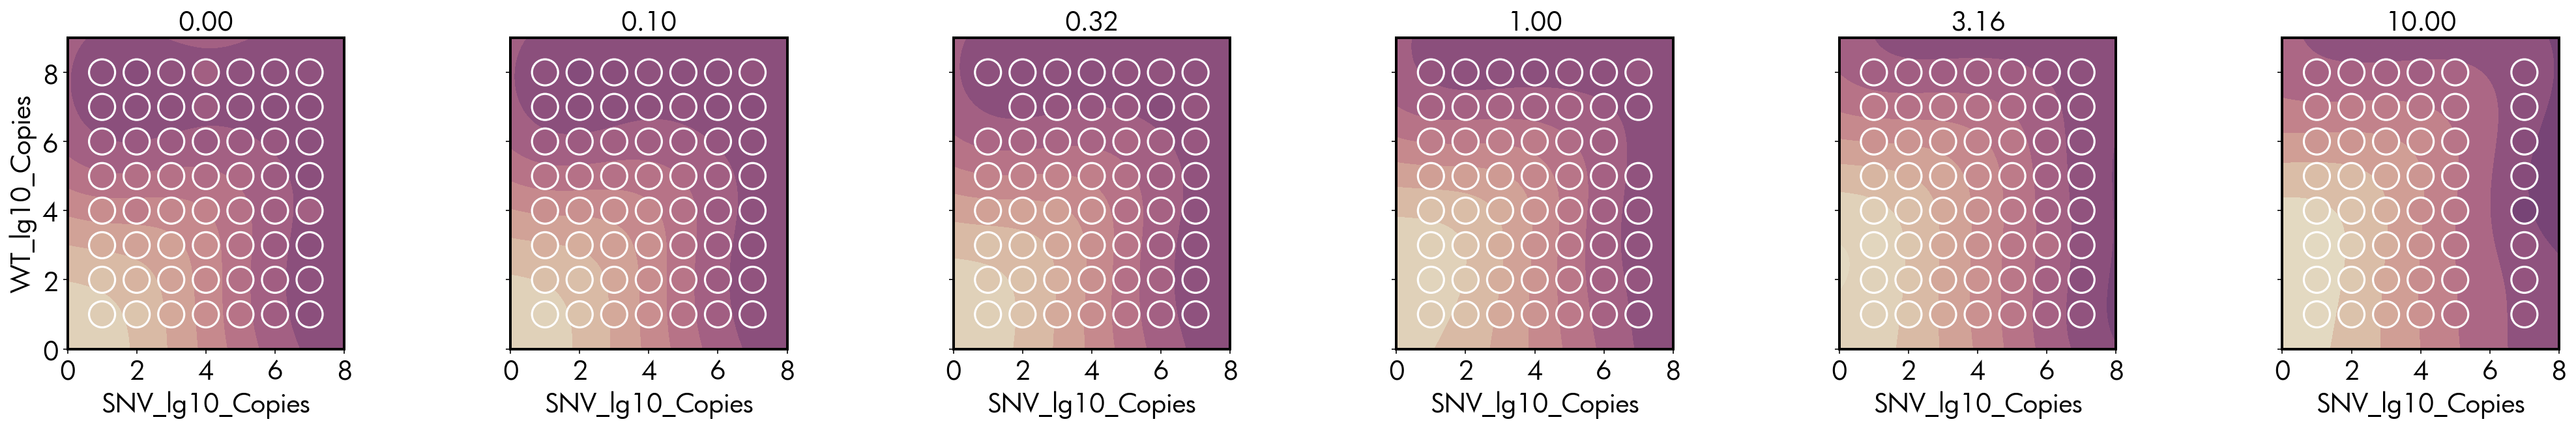

In [6]:
hue = 'SignalDifference'
extent = np.max(np.abs(nonblank_endpoints[hue]))
norm = mpl.colors.Normalize(vmin=-extent, vmax=+extent)
# norm = mpl.colors.Normalize(vmin=-1, vmax=+1)
norm = mpl.colors.Normalize()
norm(nonblank_endpoints[hue])
palette = sns.diverging_palette(220, 20)#, as_cmap=True)
cmap = sns.diverging_palette(220, 20, as_cmap=True)
cmap = sns.color_palette("ch:s=-.2,r=.6,d=0.35", n_colors=9, as_cmap=True)

g = sns.relplot(data=nonblank_endpoints, col="Blocker μM",
                x = 'SNV_lg10_Copies', y='WT_lg10_Copies',
                hue='SignalDifference', hue_norm=norm,
                palette=cmap, 
                legend=False,
                kind='scatter', height=5, aspect=1.0, s=20**2, zorder=10,
                facet_kws={
                    'margin_titles': True,
                    'despine': False})

# g.refline(y=0, color='k', linestyle=':', zorder=-11)
g.set_titles(col_template="{col_name:.2f}", row_template="{row_name}")
g.set(xticks=[0, 2, 4, 6, 8])

for col_val, ax in g.axes_dict.items():
    
    ax.set_aspect('equal')
    ax.set(yticks=[0,2,4,6,8], xticks=[0,2,4,6,8], ylim=[0,9], xlim=[0,8]);
    
    at = gp.parray(**{'Blocker μM': col_val})
    limits = gp.parray(SNV_lg10_Copies=[0,8], WT_lg10_Copies=[0,9])
    XY = gp.prepare_grid(at=at, limits=limits)
    SNV = XY['SNV_lg10_Copies']
    WT = XY['WT_lg10_Copies']
    sig = gp.predict_grid(with_noise=False)
    
    plt.sca(ax)
    pc = gmb.ParrayPlotter(x=SNV, y=WT, z=sig)(plt.contourf, cmap=cmap, norm=norm, zorder=-10)
    
plt.tight_layout();

# # can.utils.savefig('JG075A GBP6 Tripartite Curves')
can.utils.savefig(f'JG075F Signal Response Surfaces by Blocker μM (ch palette)', path=fig_pth)

Saving..Done


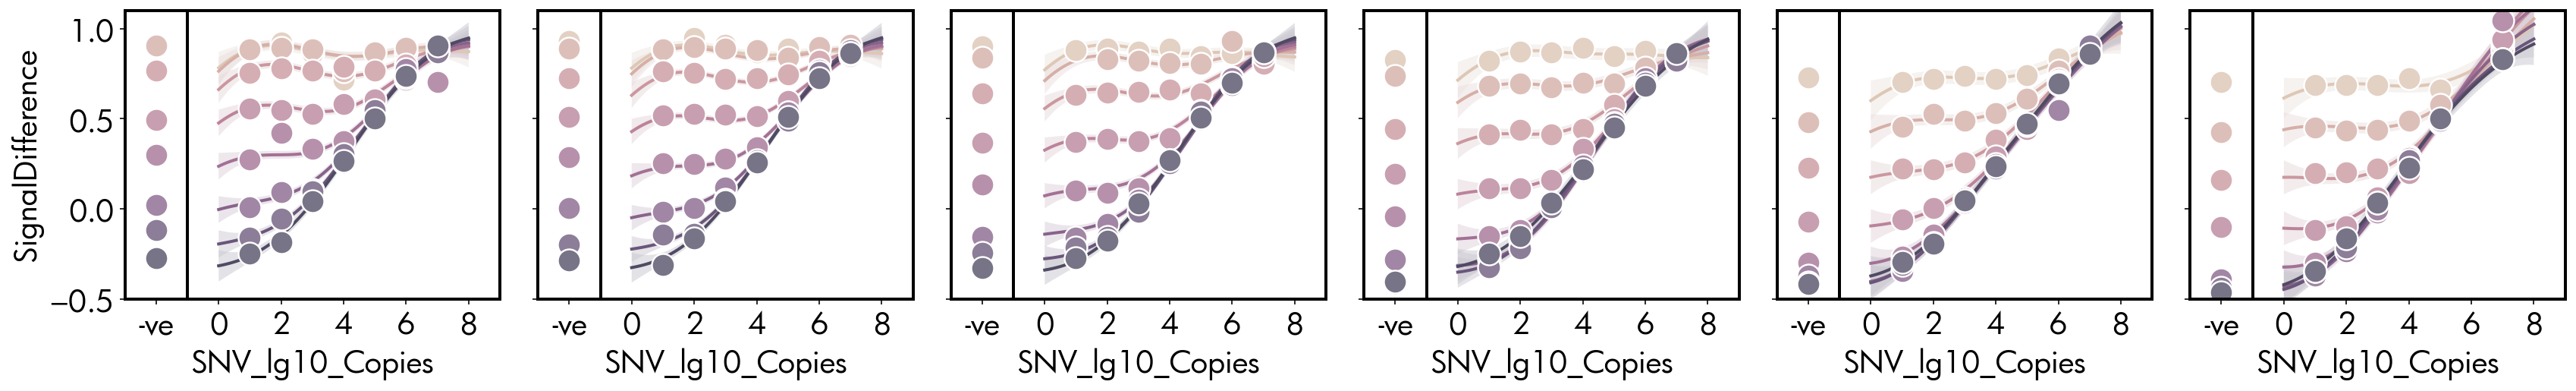

In [60]:
pal = sns.color_palette("ch:s=-.2,r=.6", n_colors=9)

g = sns.FacetGrid(data=nonblank_endpoints, col="Blocker μM",
                  height=4, aspect=1,
                  **{'margin_titles': True, 'despine': False})

for col_val, ax in g.axes_dict.items():
    for copies, rgb in zip(np.arange(1,9)[::-1], pal[1:]):
        at = gp.parray(**{'Blocker μM': col_val, 'WT_lg10_Copies': copies})
        limits = gp.parray(SNV_lg10_Copies=[0, 8])
        X = gp.prepare_grid(at=at, limits=limits)['SNV_lg10_Copies']
        sig = gp.predict_grid(with_noise=False)
        
        plt.sca(ax)
        gmb.ParrayPlotter(x=X, y=sig).plot(palette=sns.light_palette(rgb))
        
#         if copies in [1,8]:
        sns.scatterplot(data = endpoints[(endpoints["Blocker μM"]==col_val) & (endpoints["WT_lg10_Copies"]==copies)],
                        x='SNV_lg10_Copies', y='SignalDifference', s=15**2, color=sns.light_palette(rgb)[-3],
                        ax=ax)
    ax.axvline(-1, color='k')

g.set(xticks=[-2,0,2,4,6,8], xticklabels=["-ve",0,2,4,6,8], ylim=[-0.5, 1.1], xlim=[-3, 9])
plt.tight_layout();
can.utils.savefig(f'JG075F Signal Response Profiles by Blocker μM', path=fig_pth)

Saving..Done


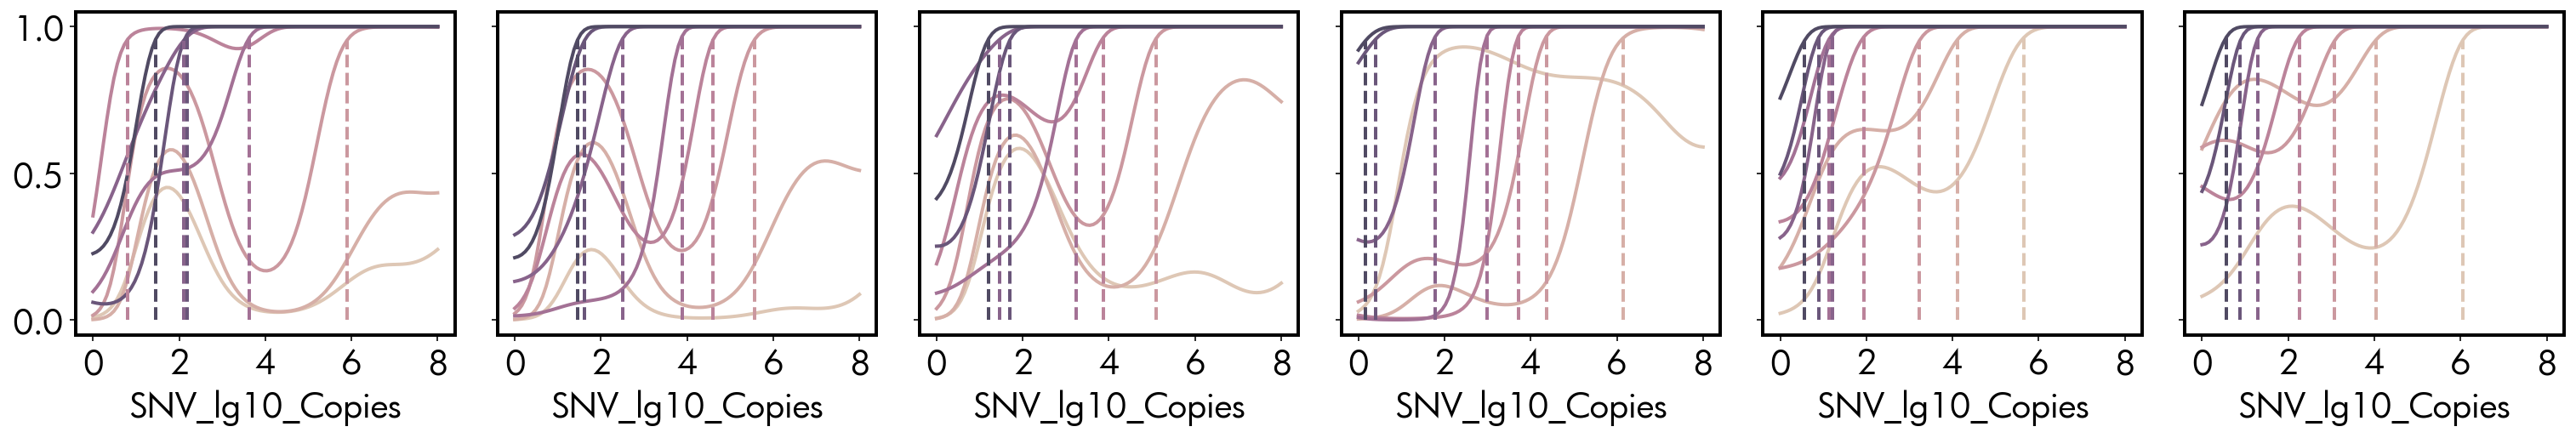

In [62]:
pal = sns.color_palette("ch:s=-.2, r=.6", n_colors=9)

g = sns.FacetGrid(data=nonblank_endpoints, col="Blocker μM",
                  height=4, aspect=0.9,
                  **{'margin_titles': True, 'despine': False})

for col_val, ax in g.axes_dict.items():
    for copies, rgb in zip(np.arange(1,9)[::-1], pal[1:]):
        at = gp.parray(**{'Blocker μM': col_val, 'WT_lg10_Copies': copies})
        limits = gp.parray(SNV_lg10_Copies=[0, 8])
        X = gp.prepare_grid(at=at, limits=limits)['SNV_lg10_Copies']
        sig = gp.predict_grid(with_noise=True)
        
        zero = endpoints[
            (endpoints["Blocker μM"]==col_val) &
            (endpoints["WT_lg10_Copies"]==copies) &
            (endpoints["SNV_lg10_Copies"]==-2)
        ]['SignalDifference']
        
        if len(zero)>0:
            plt.sca(ax)
            gmb.ParrayPlotter(x=X, y=sig.dist.sf(zero)).plot(palette=sns.light_palette(rgb))

            LOD_idx = np.argmax(sig.dist.sf(zero)>0.95)
            if LOD_idx>0:
                LOD = X[LOD_idx]
                crossing_pt = sig.dist.sf(zero)[LOD_idx]
                color=sns.light_palette(rgb)[-2]
                plt.plot([LOD, LOD], [0, crossing_pt], color=color, ls='--')
        
g.set(xticks=[0,2,4,6,8])
plt.tight_layout();
can.utils.savefig(f'JG075F LOD by Blocker μM', path=fig_pth)